# Decision Trees and Ensemble Learning - Homework

In this homework, we will use the California Housing Prices from Kaggle.

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
SEED = 1
N_JOBS = -1

In [3]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-10-22 19:59:17--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: 'housing.csv'

     0K .......... .......... .......... .......... ..........  3%  509K 3s
    50K .......... .......... .......... .......... ..........  7% 1.00M 2s
   100K .......... .......... .......... .......... .......... 10%  808K 2s
   150K .......... .......... .......... .......... .......... 14%  532K 2s
   200K .......... .......... .......... .......... .......... 17% 11.9M 1s
   250K .......... .......... .......... .......... .......... 21%  641K 1s
   300K .......... .......... .......... .......... .......... 25% 5.71M 1s
   350K .......... .......... ..

In [4]:
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
df.shape

(20640, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Data Preparation

* Keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`
* Fill missing values with zeros.
* Apply the log transform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution.
* Use the `train_test_split` function and set the `random_state` parameter to `1`.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [7]:
df = df[(df['ocean_proximity'] == '<1H OCEAN') | (df['ocean_proximity'] == 'INLAND')]
df = df.reset_index(drop=True)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN
1,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN
2,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN
3,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN
4,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN


In [8]:
df['ocean_proximity'].value_counts()

<1H OCEAN    9136
INLAND       6551
Name: ocean_proximity, dtype: int64

In [9]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [10]:
df['total_bedrooms'] = df['total_bedrooms'].fillna(0)
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [11]:
df['median_house_value'] = np.log1p(df['median_house_value'])
df['median_house_value'].head()

0    12.973866
1    12.287657
2    12.419574
3    12.554971
4    12.287196
Name: median_house_value, dtype: float64

In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=SEED)

In [13]:
assert len(df) == len(df_train) + len(df_val) + len(df_test)

In [14]:
len(df_train), len(df_val), len(df_test)

(9411, 3138, 3138)

In [15]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [16]:
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

In [17]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [18]:
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')


In [19]:
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable.

* Train a model with `max_depth=1`

Which feature is used for splitting the data?
* `ocean_proximity`
* `total_rooms`
* `latitude`
* `population`

In [20]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [21]:
print(export_text(dt, feature_names=[*dv.get_feature_names_out()]))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



`ocean_proximity` feature was used for splitting the data.

## Question 2

Train a random forest model with these parameters:
* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)

What's the RMSE of this model on validation?
* 0.045
* 0.245
* 0.545
* 0.845

In [22]:
rf = RandomForestRegressor(n_estimators=10, random_state=SEED, n_jobs=N_JOBS)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [23]:
y_pred = rf.predict(X_val)

In [24]:
rmse = mean_squared_error(y_val, y_pred, squared=False)
round(rmse, 3)

0.245

RMSE of the model on the validation dataset is 0.245.

## Question 3

Now let's experiment with the `n_estimators` parameter
* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.

After which value of `n_estimators` does RMSE stop improving? Consider 3 decimal places for retrieving the answer.
* 10
* 25
* 50
* 160

In [25]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=SEED, n_jobs=N_JOBS)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    rmse_score = mean_squared_error(y_val, y_pred, squared=False)

    scores.append((n, rmse_score))

  0%|          | 0/20 [00:00<?, ?it/s]

In [26]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'RMSE'])
df_scores['RMSE'] = df_scores['RMSE'].round(3)
df_scores

,n_estimators,RMSE
0,10,0.245
1,20,0.239
2,30,0.237
3,40,0.236
4,50,0.235
5,60,0.235
6,70,0.234
7,80,0.235
8,90,0.235
9,100,0.234


Text(0, 0.5, 'RMSE')

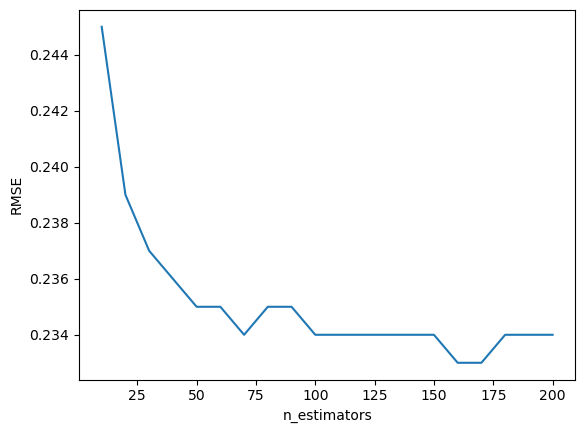

In [27]:
plt.plot(df_scores['n_estimators'], df_scores['RMSE'])
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

RMSE stops improving after 160 `n_estimators`.

## Question 4

Let's select the best `max_depth`:
* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values
    * try different values of `n_estimators` from 10 till 200 (with step 10)
    * calculate the mean RMSE
* Fix the random seed: `random_state=1`

What's the best `max_depth`, using the mean RMSE?
* 10
* 15
* 20
* 25

In [28]:
depth = [10, 15, 20, 25]

In [29]:
scores = []

for d in tqdm(depth, desc='max_depth'):
    for n in tqdm(range(10, 201, 10), desc='n_estimators', leave=False):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=SEED, n_jobs=N_JOBS)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse_score = mean_squared_error(y_val, y_pred, squared=False)

        scores.append((d, n, rmse_score))

max_depth:   0%|          | 0/4 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/20 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/20 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/20 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/20 [00:00<?, ?it/s]

In [30]:
columns = ['max_depth', 'n_estimators', 'RMSE']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores['RMSE'] = df_scores['RMSE'].round(3)
df_scores.head()

,max_depth,n_estimators,RMSE
0,10,10,0.251
1,10,20,0.248
2,10,30,0.246
3,10,40,0.245
4,10,50,0.246


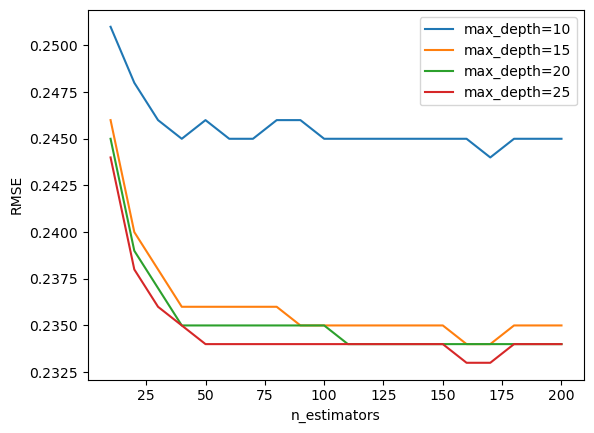

In [31]:
for d in depth:
    df_subset = df_scores[df_scores['max_depth'] == d]

    plt.plot(df_subset['n_estimators'], df_subset['RMSE'], label=f'max_depth={d}')

plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.legend()
    

The lowest RMSE is achieved with `max_depth=25`.

## Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:
* Train the model with these parameters:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

What's the most important feature (among these 4)?
* `total_rooms`
* `median_income`
* `total_bedrooms`
* `longitude`

In [32]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=SEED, n_jobs=N_JOBS)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [33]:
features = [*dv.get_feature_names_out()]
feature_importances = [*zip(features, rf.feature_importances_)]
feature_importances

[('households', 0.01513609844681855),
 ('housing_median_age', 0.030317256108796153),
 ('latitude', 0.10200703165624685),
 ('longitude', 0.08624381391950157),
 ('median_income', 0.33561112799548903),
 ('ocean_proximity=<1H OCEAN', 0.29247296545343093),
 ('ocean_proximity=INLAND', 0.07380644294558006),
 ('population', 0.027136059019747173),
 ('total_bedrooms', 0.015852218895139155),
 ('total_rooms', 0.021416985559250513)]

In [34]:
df_feature_importance = pd.DataFrame(feature_importances, columns=['feature', 'importance'])
df_feature_importance['importance'] = df_feature_importance['importance'].round(3)
df_feature_importance.sort_values(by='importance', ascending=False)

,feature,importance
4,median_income,0.336
5,ocean_proximity=<1H OCEAN,0.292
2,latitude,0.102
3,longitude,0.086
6,ocean_proximity=INLAND,0.074
1,housing_median_age,0.030
7,population,0.027
9,total_rooms,0.021
8,total_bedrooms,0.016
0,households,0.015


The most important feature is `median_income`. Its score is 0.336.

## Question 6

Let's train an XGBoost model. For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

In [35]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [36]:
import xgboost as xgb


In [37]:
def parse_xgb_output(output, eval_metric):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', f'train_{eval_metric}', f'val_{eval_metric}']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [38]:
features = [f.replace('=<', '_').replace('=', '_') for f in features]
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [39]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [40]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [41]:
df_score = parse_xgb_output(output, 'rmse')
df_score[['train_rmse', 'val_rmse']] = df_score[['train_rmse', 'val_rmse']].round(3)
df_score

,num_iter,train_rmse,val_rmse
0,0,0.444,0.442
1,1,0.366,0.369
2,2,0.316,0.324
3,3,0.285,0.300
4,4,0.266,0.284
...,...,...,...
95,95,0.112,0.229
96,96,0.111,0.229
97,97,0.111,0.229
98,98,0.110,0.229


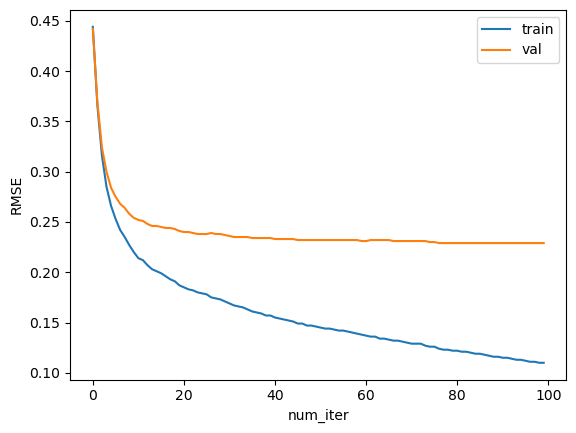

In [42]:
plt.plot(df_score['num_iter'], df_score['train_rmse'], label='train')
plt.plot(df_score['num_iter'], df_score['val_rmse'], label='val')
plt.xlabel('num_iter')
plt.ylabel('RMSE')
plt.legend()

Text(0, 0.5, 'RMSE')

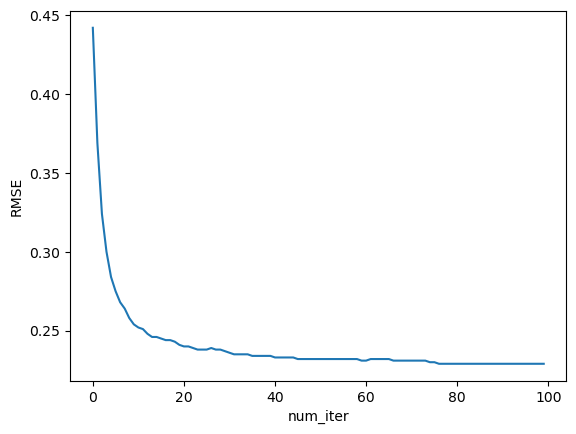

In [43]:
plt.plot(df_score['num_iter'], df_score['val_rmse'], label='val')
plt.xlabel('num_iter')
plt.ylabel('RMSE')

Now change `eta` from `0.3` to `0.1`.

In [44]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist)

In [45]:
df_score = parse_xgb_output(output, 'rmse')
df_score[['train_rmse', 'val_rmse']] = df_score[['train_rmse', 'val_rmse']].round(3)
df_score

,num_iter,train_rmse,val_rmse
0,0,0.524,0.520
1,1,0.487,0.484
2,2,0.454,0.453
3,3,0.425,0.426
4,4,0.400,0.401
...,...,...,...
95,95,0.166,0.233
96,96,0.165,0.233
97,97,0.164,0.232
98,98,0.164,0.232


Text(0, 0.5, 'RMSE')

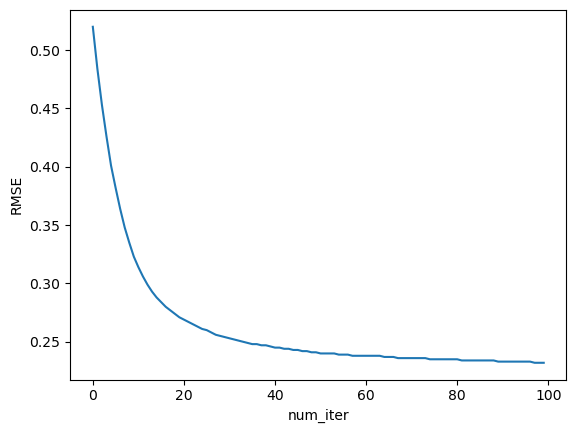

In [46]:
plt.plot(df_score['num_iter'], df_score['val_rmse'], label='val')
plt.xlabel('num_iter')
plt.ylabel('RMSE')

Which eta leads to the best RMSE score on the validation dataset?
* 0.3
* 0.1
* Both give equal value

`eta=0.3` leads to the better RMSE score on the validation dataset.